![Py4Eng](img/logo.png)

# Recurrent Neural Networks
## Yoav Ram

In this session we will understand:
- what recurrent neural network and how they work, and
- how memory and state can be implemented in neural networks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from random import uniform

In developing this RNN we will follow [Andrej Karpathy](http://cs.stanford.edu/people/karpathy/)'s [blogpost about RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness) ([original code gist](https://gist.github.com/karpathy/d4dee566867f8291f086) with BSD License).

The data is just text data, in this case Shakespear's writing.

In [2]:
filename = '../data/shakespear.txt'
text = open(filename, 'rt').read()
print("Number of characters: {}".format(len(text)))
print("Number of unique characters: {}".format(len(set(text))))
print("Number of lines: {}".format(text.count('\n')))
print("Number of words: {}".format(text.count(' ')))
print()
print("Excerpt:")
print("*" * len("Excerpt:"))
print(text[:500])

Number of characters: 99993
Number of unique characters: 62
Number of lines: 3298
Number of words: 15893

Excerpt:
********
That, poor contempt, or claim'd thou slept so faithful,
I may contrive our father; and, in their defeated queen,
Her flesh broke me and puttance of expedition house,
And in that same that ever I lament this stomach,
And he, nor Butly and my fury, knowing everything
Grew daily ever, his great strength and thought
The bright buds of mine own.

BIONDELLO:
Marry, that it may not pray their patience.'

KING LEAR:
The instant common maid, as we may less be
a brave gentleman and joiner: he that finds u


# Preparations

We start by creating 
- a list `chars` of the unique characters
- `data_size` the number of total characters
- `vocab_size` the number of unique characters
- `idx_to_char` a dictionary from index to char
- `char_to_idx` a dictionary from char to index
and then we convert `data` from a string to a NumPy array integers representing the chars via their indexes.

In [6]:
chars = list(set(text))
data_size, vocab_size = len(text), len(chars)

idx_to_char = dict(enumerate(chars)) # { i: ch for i,ch in enumerate(chars) }
char_to_idx = dict(zip(idx_to_char.values(), idx_to_char.keys())) # { ch: i for i,ch in enumerate(chars) }
data = np.array([char_to_idx[c] for c in text], dtype=int)

Let's get some of the functions we already know out of the way:

In [7]:
def softmax(x):
    x = x.squeeze()
    expx = np.exp(x - x.sum())
    return expx / expx.sum()

def cross_entropy(predictions, targets):
    return sum([-np.log(p[t]) for p, t in zip(predictions, targets)])

In [23]:
def average(prev, curr, β):
    return [
        β * p + (1 - β) * c
        for p, c
        in zip(prev, curr)
    ]
    
class AdamOptimizer:
    def __init__(self, α=0.001, β1=0.9, β2=0.999, ϵ=1e-8):
        self.α = α
        self.β1 = β1
        self.β2 = β2
        self.ϵ = ϵ
        self.m = None
        self.v = None
        self.t = 0

    def send(self, gradients):
        if self.m is None:
            self.m = [0] * len(gradients)
        if self.v is None:
            self.v = [0] * len(gradients)

        self.t += 1
        αt = self.α * np.sqrt(1 - self.β2**self.t) / (1 - self.β1**self.t)
        self.m = average(self.m, gradients, self.β1)        
        self.v = average(self.v, (g*g for g in gradients), self.β2)

        updates = [-αt * mi / (np.sqrt(vi) + self.ϵ) for mi, vi in zip(self.m, self.v)]
        for upd in updates:
            assert np.isfinite(upd).all()
        return updates

# RNN model

- $x(t)$ is the $t$ character, one-hot encoded and a 1D array of length `vocab_size`.
- $h(t)$ is the state of the hidden memory layer after seeing $t$ characters, encoded as a 1D array of numbers (neurons...)
- $\widehat y(t)$ is the prediction of the network after seeing $t$ characters, encoded as a 1D array of probabilities of length `vocab_size`

The model is then written as:

$$
h(t) = \tanh{\big(x(t) \cdot W_x^h + h(t-1) \cdot W_h^h + b_h\big)} \\
\widehat y(t) = softmax\big(h(t) \cdot W_h^y\big)
$$

and we set $h(0) = (0, \ldots, 0)$.

This operation will be performed by our `step` function.

The `feed_forward` function will loop over a sequence of $x=(x_1, x_2, \ldots, x_k)$ of some arbitray size - similar to batches in the FFN and CNN frameworks.

In [10]:
def step(params, x_t, h_t_1=None):
    Wxh, Whh, Why, bh, by = params
    if h_t_1 is None:
        h_t_1 = np.zeros(h_size)    
    if h_t_1.ndim == 1:
        h_t_1 = h_t_1.reshape(-1, 1)
    if x_t.ndim == 1:
        x_t = x_t.reshape(-1, 1)

    # update hidden layer
    h_t = np.tanh(Wxh @ x_t + Whh @ h_t_1 + bh)
    # fully connected layer
    z_t = Why @ h_t + by
    z_t = z_t.squeeze()
    h_t = h_t.squeeze()
    # softmax readout layer
    yhat_t = softmax(z_t)
    return h_t, z_t, yhat_t

def feed_forward(params, x, h0=None):
    if h0 is None:
        h0 = np.zeros(h_size)
    h = {-1: h0}
    
    shape = (len(x), vocab_size)
    x_original = x.copy()
    x, z, yhat = np.zeros(shape), np.empty(shape), np.empty(shape)
    
    for t, char_idx in enumerate(x_original):
        x[t, char_idx] = 1.0 # one-hot encoding input into xs  
        h[t], z[t, :], yhat[t, :] = step(params, x[t, :], h[t-1])

    return x, h, z, yhat

# Back propagation and "unrolling" the network

Back propagation works, as before, using the chain rule. 
It is similar to the [FFN example](FFN.ipynb), except that the $h$ layer adds a bit of complexity, but not much.

The details of the gradient calculation can be found in Stanford's ["Convolutional Neural Networks for Visual Recognition" course](http://cs231n.github.io/neural-networks-case-study/#grad).

What's important to discuss is that instead of back propagating a single step of the network $t$, we back propagate over a sequence of steps, that is over $x=(x_1, \ldots, x_k)$ for some arbitrary $k$.

![rolled RNN](img/rolled_rnn.png)

How? By "unrolling" the network.

![Unrolled RNN](img/unrolled_rnn.png)

For example, for $k=3$, the input is $x=[x(1), x(2), x(3)]$, and we can write

$$
h(1) = \tanh{\big(x(1) \cdot W_x^h + h(0) \cdot W_h^h + b_h\big)} \\
\widehat y(1) = softmax\big(h(1) \cdot W_h^y\big) \\
h(2) = \tanh{\big(x(2) \cdot W_x^h + h(1) \cdot W_h^h + b_h\big)} \\
\widehat y(2) = softmax\big(h(2) \cdot W_h^y\big) \\
h(3) = \tanh{\big(x(3) \cdot W_x^h + h(2) \cdot W_h^h + b_h\big)} \\
\widehat y(3) = softmax\big(h(3) \cdot W_h^y\big)
$$

The cross entropy is computed by summing over all $\widehat y(t)$ together, and then the gradient is computed for this cross entropy with respect to the various $W$ and $b$ parameters.

In [11]:
def back_propagation(params, x, y, h0=None):
    """Calculates loss and gradiens of loss wrt paramters
    
    See http://cs231n.github.io/neural-networks-case-study/#grad
    
    Parameters
    ----------
    params : list of arrays
        model parameters
    x, y : list of integers
        indices of characters for the input and target of the network
    h : np.ndarray
        initial hidden state of shape Hx1
    Returns
    -------
    loss : float
        value of loss function
    dWxh, dWhh, dWhy, dbh, dby 
        gradients of the loss function wrt to model parameters
    h0 : np.ndarray
        initial hidden state
    """
    n_inputs = len(x)
    # forward pass: compute predictions and loss going forwards
    x, h, z, yhat = feed_forward(params, x, h0=h0)
    loss = cross_entropy(yhat, y)
    
    # backward pass: compute gradients going backwards
    Wxh, Whh, Why, bh, by = params
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dh_next = np.zeros_like(h[0])
    
    # back propagate through the unrolled network
    for t in reversed(range(len(y))):
        # backprop into y
        x_t, h_t, yhat_t, y_t = x[t], h[t], yhat[t], y[t] # can't zip because hs is not ordered
        dyhat = yhat_t.copy()
        dyhat[y_t] -= 1 # Yhat - Y
        dWhy += np.outer(dyhat, h_t)  # outer product, same as dy.reshape(-1, 1) @ h.reshape(1, -1)
        dby += dyhat.reshape(-1, 1) # dby is a column vector
        # backprop into h_t
        dh = Why.T @ dyhat + dh_next
        # backprop through tanh nonlinearity
        dh = (1 - h_t * h_t) * dh # tanh'(x) = 1-x^2
        dbh += dh.reshape(-1, 1) # dbh is a column vector
        dWxh += np.outer(dh, x_t)
        dWhh += np.outer(dh, h[t-1]) # try to use h[t] instead of h[t-1] and see effect in grad_check
        dh_next = Whh.T @ dh

    gradients = dWxh, dWhh, dWhy, dbh, dby
    for grad in gradients:
        # clip to mitigate exploding gradients
        np.clip(grad, -5, 5, out=grad) # out=grad makes this run in-place
    return loss, gradients, h[n_inputs-1]

The trainer is similar to previous trainers, it goes through the data in `seq_length` batches and then calculates gradients and updates parameters.
`seq_length` is not just the batch size for the stochastic gradient descent but also the number of steps to "unroll" the network.

In [19]:
def trainer(params, data, seq_length):
    optimizer = AdamOptimizer()
    t, pos, h = 0, 0, None
    while True:
        t += 1
        if pos + seq_length + 1 >= len(data):
            # reset data position and hidden state
            pos, h = 0, None
        x = data[pos : pos + seq_length]
        y = data[pos + 1 : pos + seq_length + 1]
        
        loss, gradients, h = back_propagation(params, x, y, h)
        Δs = optimizer.send(gradients)
        for par, Δ in zip(params, Δs):
            par += Δ
        pos += seq_length
        yield t, loss, h

# Sampling from the network

Finally, instead of a `predict` function, we have a `sample` function, which, given the parameters $W$s and $b$s), a seed char, number of chars, and an state for the hidden layer, produces a sample of text from the network.

It does so by using the seed as $x(1)$ and drawing $x(t)$ for $t>1$ from the distribution given by $\widehat y(t)$.

![](img/sampling_rnn.png)

In [20]:
def sample(params, seed_idx, num_samples, h0=None):
    x = np.zeros((num_samples + 1, vocab_size), dtype=float)
    x[0, seed_idx] = 1
    idx = np.empty(num_samples, dtype=int)
    h_t = h0
    for t in range(num_samples):
        h_t, _, yhat_t = step(params, x[t, :], h_t)
        # draw from output distribution
        idx[t] = np.random.choice(range(vocab_size), p=yhat_t.ravel())        
        x[t + 1, idx[t]] = 1
    chars = (idx_to_char[i] for i in idx)
    return str.join('', chars)

# Training the network

We can now initialize the parameters and meta-parameters:

In [27]:
h_size = 100 # number of units in hidden layer
seq_length = 25 # number of steps to unroll the RNN for
max_train_step = 100000

Wxh = np.random.randn(h_size, vocab_size) * 0.01 
Whh = np.random.randn(h_size, h_size) * 0.01
Why = np.random.randn(vocab_size, h_size) * 0.01 
bh = np.zeros((h_size, 1)) # hidden layer bias
by = np.zeros((vocab_size, 1)) # readout layer bias

params = Wxh, Whh, Why, bh, by
train = trainer(params, data, seq_length)

In [29]:
for t, loss, h in train:
    if t % (max_train_step//10) == 0:
        sample_text = sample(params, 0, 200)
        print(sample_text)
        print()
        print('train step {:d}, loss: {:.2g}'.format(t, loss))
        print('-'*80)
    if t == 100000:
        break

alsnithe een turf
Five beed,

RAAHY:
OnI yee aceye iron me tith-Whe,
Tour celloud magiMed rouete titheg I Ar thein bke toind-brom bu hor oun oun mitrhees that hot cnry magn ist es wpasdyn lud heot.
AA

train step 10000, loss: 52
--------------------------------------------------------------------------------
an any pncaalt coaid.

FFOS:
Hatut, palltepd.

IAS:
Mat an mao dir s om  hake stoyde eull shee nealdaf.

TaLld:
Rofld whin sith therulnint bise?l, argebshet bedcere: be ant than ghny go nonle thenliin

train step 20000, loss: 66
--------------------------------------------------------------------------------
 my a seast urcis shall'd cragh, Hat? at Mendin tcterer ware my youn
And ace lall hiidk rey of but;
Mare,
Themeed to I hellis:
WIa in my. do fome breppeis tneart.

FAGBENIS:
Chite mrine wishe to ceith

train step 30000, loss: 59
--------------------------------------------------------------------------------
e hycAStcet she prake afrenofist be in lmagstojsent heshe angro Cama,


# RNN with Keras

We will write a similar RNN, with the application of [predicting word completions](http://curiousily.com/data-science/2017/05/23/tensorflow-for-hackers-part-5.html) for [Jonathan Swift](https://en.wikipedia.org/wiki/Jonathan_Swift), the author of Gulliver's Travels.

In [6]:
import pickle

import numpy as np
import heapq
from tensorflow import keras

The data is at `../data/Gulliver.txt` and contains the Project Gutenberg's version of the book.

In [3]:
with open('../data/Gulliver.txt') as f:
    text = f.read().lower()

chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 59


We'll use sequences of length 40 and unroll 3 steps at a time.

In [4]:
seq_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
    sentences.append(text[i: i + seq_len])
    next_chars.append(text[i + seq_len])
print(f'num training examples: {len(sentences)}')

num training examples: 102845


In [7]:
X = np.zeros((len(sentences), seq_len, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Here we define the model using Keras' succint API - an [LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) (a common and efficient type of RNN) with 128 hidden nodes, followed by a multinomial logistic layer (dense=fully-connected).

![LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png)

In [9]:
layers = [
    keras.layers.LSTM(128, input_shape=(seq_len, len(chars))),
    keras.layers.Dense(len(chars)),
    keras.layers.Activation('softmax')
]
model = keras.models.Sequential(layers)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               96256     
_________________________________________________________________
dense_2 (Dense)              (None, 59)                7611      
_________________________________________________________________
activation_2 (Activation)    (None, 59)                0         
Total params: 103,867
Trainable params: 103,867
Non-trainable params: 0
_________________________________________________________________


We'll train with the Adam optimizer, the cross entropy loss function, and use accuracy as a performance metric. 
To measure accuracy on a test set, we tell Keras to split 5% of the data for a testset.

Other training parameters are the batch size - number of samples or sequences per gradient update - and epochs - number of times we want to iterate over the entire data.

A nice feature is that we can get the training history object which contains logging data.

In [39]:
optimizer = keras.optimizers.Adam()
model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy']
)

history = model.fit(
    X, y, 
    validation_split=0.05, 
    batch_size=128, 
    epochs=20, 
    shuffle=True).history

Train on 97702 samples, validate on 5143 samples
Epoch 1/20
97702/97702 [==============================] - 43s 444us/step - loss: 2.7247 - acc: 0.2461 - val_loss: 2.6824 - val_acc: 0.2543
Epoch 2/20
97702/97702 [==============================] - 41s 421us/step - loss: 2.3349 - acc: 0.3276 - val_loss: 2.5307 - val_acc: 0.2917
Epoch 3/20
97702/97702 [==============================] - 39s 397us/step - loss: 2.1851 - acc: 0.3646 - val_loss: 2.4589 - val_acc: 0.3169
Epoch 4/20
97702/97702 [==============================] - 41s 424us/step - loss: 2.0862 - acc: 0.3902 - val_loss: 2.4049 - val_acc: 0.3284
Epoch 5/20
97702/97702 [==============================] - 42s 435us/step - loss: 2.0122 - acc: 0.4099 - val_loss: 2.3510 - val_acc: 0.3488
Epoch 6/20
97702/97702 [==============================] - 40s 414us/step - loss: 1.9506 - acc: 0.4247 - val_loss: 2.3067 - val_acc: 0.3683
Epoch 7/20
97702/97702 [==============================] - 40s 408us/step - loss: 1.8997 - acc: 0.4378 - val_loss: 2.2

Models can be saved to HDF5 files, history can be pickled.

In [40]:
model.save('../data/keras_rnn_model.h5')
with open("history.p", "wb") as f:
    pickle.dump(history, f)

In [18]:
model = keras.models.load_model('../data/keras_rnn_model.h5')
with open("history.p", "rb") as f:
    history = pickle.load(f)

Here we plot the change in accuracy and loss over the training time:

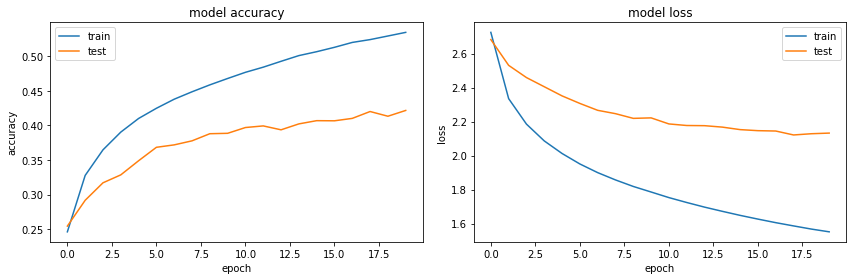

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(history['acc'], label='train')
ax.plot(history['val_acc'], label='test')
ax.set(
    title='model accuracy',
    ylabel='accuracy',
    xlabel='epoch'
)
ax.legend()

ax = axes[1]
ax.plot(history['loss'], label='train')
ax.plot(history['val_loss'], label='test')
ax.set(
    title='model loss',
    ylabel='loss',
    xlabel='epoch'
)
ax.legend()
    
fig.tight_layout()

Now let's apply the model for text completion.

First, a one-hot encoder.

In [20]:
def prepare_input(text):
    x = np.zeros((1, seq_len, len(chars)))
    for t, char in enumerate(text[:seq_len]):
        x[0, t, char_indices[char]] = 1.        
    return x

The next function samples from $\widehat y$, the character probabilities.

In [21]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

The next two function gets input text and predicts at least two more characters until space is encountered.

In [22]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]

        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

Finally, the next one makes several predictions, that is, samples the completion distribution.

In [23]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [
        indices_char[idx] + predict_completion(
                                text[1:] + indices_char[idx]) 
        for idx in next_indices
    ]

Let's try it with some actual quotes from the book.

In [24]:
quotes = [
    'I likewise delivered up my watch, which the emperor was very curious to see',
    'I lay all this while, as the reader may believe, in great uneasiness.',
    'But I should have mentioned, that before the principal person began his oration',
    'After they were read, I was demanded to swear to the performance of them',
    'extending its edges round as wide as his majesty\'s bed-chamber'
]

In [25]:
for q in quotes:
    seq = q[:seq_len].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

i likewise delivered up my watch, which 
['i ', 'was ', 'the ', 'had ', 'all ']

i lay all this while, as the reader may 
['of ', 'the ', 'he ', 'a ', 'which ']

but i should have mentioned, that before
[' of ', ', ', '\nhis ', '. ', 's ']

after they were read, i was demanded to 
['the ', 'my ', 'be ', 'his ', 'see ']

extending its edges round as wide as his
[' majesty ', '\nmajesty ', 'her ', 'e ', ', ']



## Exercise

Try to run it on some of your text.
For example, you can save your terminal history to a file and let the network train on that (`history > history.txt` then remove the line numbers using text editor or even Python).
Another option is to feed it with your source code: choose some project, read all source files (you can use [`os.walk`](https://docs.python.org/3.5/library/os.html#os.walk)), and feed it to the network.

Have fun.

# References

- TensorFlow [RNN tutorial](https://www.tensorflow.org/tutorials/recurrent)
- Andrej Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) blogpost
- [Obama-RNN](https://medium.com/@samim/obama-rnn-machine-generated-political-speeches-c8abd18a2ea0) by samim.
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization) on Stanford's "Unsupervised Feature Learning and Deep Learning" tutorial
- [Making a Predictive Keyboard using Recurrent Neural Networks](http://curiousily.com/data-science/2017/05/23/tensorflow-for-hackers-part-5.html) by Venelin Valkov

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Deep Learning for Software Developers_](https://python.yoavram.com/Deep4Devs) course.

The notebook was written using [Python](http://python.org/) 3.6.3, [IPython](http://ipython.org/) 6.2.1, [Jupyter](http://jupyter.org) 5.1.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)